# Cleaning and Augmentation
This notebook is meant to read in the data downloaded from reddit and prepare it for analysis by cleaning it and doing some computation...

But is has become my whole analysis - sorry...

## Setup

In [129]:
import pandas as pd
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import collections

In [130]:
# Change this to analyze something else

# ## a big one:
# subreddit = "enlightenedbirdmen"
# download_date_string = "19.12.04-14:27:14"

# ## a meduim one:
# subreddit = "justwriterthings"
# download_date_string = "19.12.04-10:30:56"

# ## a small one:
# subreddit = "The_B_Emoji"
# download_date_string = "19.12.04-09:28:30"

# ## a very small one:
# subreddit = "GamesWithHorses"
# download_date_string = "19.12.04-10:33:02"

# subreddit = "relationship_advice"
# download_date_string = "19.12.05-20:17:26"

# subreddit = "Showerthoughts"
# download_date_string = "19.12.05-20:40:00"

subreddit = "todayilearned"
download_date_string = "19.12.05-19:38:34"

In [131]:
# Constants
data_directory = "downloads/"
submissions_suffix = "-submissions-" + download_date_string + ".csv"
comments_suffix = "-comments-" + download_date_string + ".csv"

## Read the Data

In [132]:
# Read the submissions
submissions_file = data_directory + subreddit + submissions_suffix
submissions = pd.read_csv(submissions_file, index_col=0)
submissions.head()

,submission_id,user,utc,score,title,body,subreddit
0,e6qdg8,purplealienandproud,1.575591e+09,4,TIL Religious groups in America normally have ...,NaN,todayilearned
1,e6qcx9,SamWilber,1.575591e+09,1,TIL an oil change for a Lamborghini costs over...,NaN,todayilearned
2,e6q587,CanuckBacon,1.575590e+09,12,"TIL that when considering what to name Idaho, ...",NaN,todayilearned
3,e6q3qk,ResidentDoctorEvil,1.575590e+09,6,TIL the practice of family restaurants seating...,NaN,todayilearned
4,e6q1fd,Randomosaur,1.575590e+09,8,TIL spotted hyenas are able to digest all orga...,NaN,todayilearned


In [133]:
# Read the comments
comments_file = data_directory + subreddit + comments_suffix
comments = pd.read_csv(comments_file, index_col=0)
comments.head()

,comment_id,submission_id,user,utc,score,body
0,f9sfnw5,t3_e6qdg8,leadchipmunk,1.575592e+09,1,"Yo, who wants some popcorn? This is going to g..."
1,f9sfrk9,t3_e6qdg8,Noctis_Raptor,1.575592e+09,1,NERD FIGHT!
2,f9sfnu8,t3_e6qcx9,Noctis_Raptor,1.575592e+09,1,To someone who can comfortably afford a Lambor...
3,f9sf6jl,t3_e6q587,textoen,1.575591e+09,1,I thought it was short for Idunno? What shall ...
4,f9sf6k4,t3_e6q587,Populistless,1.575591e+09,1,No you da ho!


## Data Cleaning

In [134]:
# Remove the t3_ prefix from comment submission ids
comments["submission_id"] = comments["submission_id"].apply(lambda s: s.split("t3_")[1])

# Empty content should be the empty string - not nan
submissions['body'] = submissions['body'].fillna(value="")
comments['body'] = comments['body'].fillna(value="")

## Data Conversion

In [135]:
# Convert utc to date
submissions['date'] = submissions['utc'].apply(datetime.datetime.utcfromtimestamp)
comments['date'] = comments['utc'].apply(datetime.datetime.utcfromtimestamp)
#submissions.head()
comments.head()

,comment_id,submission_id,user,utc,score,body,date
0,f9sfnw5,e6qdg8,leadchipmunk,1.575592e+09,1,"Yo, who wants some popcorn? This is going to g...",2019-12-06 00:18:30
1,f9sfrk9,e6qdg8,Noctis_Raptor,1.575592e+09,1,NERD FIGHT!,2019-12-06 00:19:25
2,f9sfnu8,e6qcx9,Noctis_Raptor,1.575592e+09,1,To someone who can comfortably afford a Lambor...,2019-12-06 00:18:30
3,f9sf6jl,e6q587,textoen,1.575591e+09,1,I thought it was short for Idunno? What shall ...,2019-12-06 00:14:05
4,f9sf6k4,e6q587,Populistless,1.575591e+09,1,No you da ho!,2019-12-06 00:14:05


In [136]:
# Ensure time ordering of submissions
submissions = submissions.sort_values(['date'], ascending = [1]).reset_index()
submissions.head()

,index,submission_id,user,utc,score,title,body,subreddit,date
0,974,e2mek4,Lard_Baron,1.574887e+09,53,"TIL of Joan of Leeds, an English nun, who, bor...",,todayilearned,2019-11-27 20:40:08
1,973,e2mpwt,NobskaWoodsHole,1.574888e+09,35,TIL that both Mama Cass and Keith Moon died in...,,todayilearned,2019-11-27 21:00:30
2,972,e2msqp,ThatLocalPessimist,1.574889e+09,48335,Today I learned that Ringo Starr was the narra...,,todayilearned,2019-11-27 21:05:37
3,971,e2mtlo,noooodlearms,1.574889e+09,1043,"TIL: In 1995, an artist named William Utermohl...",,todayilearned,2019-11-27 21:07:07
4,970,e2mxse,Dota2Ethnography,1.574889e+09,237,"TIL of El Mahrousa, the official presidential ...",,todayilearned,2019-11-27 21:14:45


## Pagerank
This uses [networkx](https://networkx.github.io/documentation/networkx-1.10/index.html)

In [137]:
# # proff that directed edges are defined (start, end)
# d = nx.DiGraph()
# d.add_node(1)
# d.add_node(2)
# d.add_edge(1, 2)
# nx.draw_networkx(d)

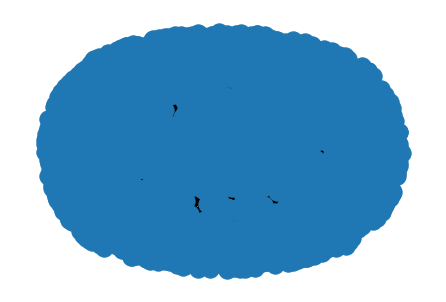

In [138]:
# Start by creating a directed graph
g = nx.DiGraph()

# Each user is a node in the graph
g.add_nodes_from(set(submissions['user'].append(comments['user'])))

# Each comment is a directed edge
pd.merge(submissions, comments, on='submission_id') \
    .apply(lambda row: g.add_edge(row["user_y"], row["user_x"]), axis=1)

# Visualize the graph
nx.draw(g)
plt.show()

In [139]:
# Now lets calculate pagerank
pagerank = nx.pagerank(g)
#pagerank # uncomment to preview

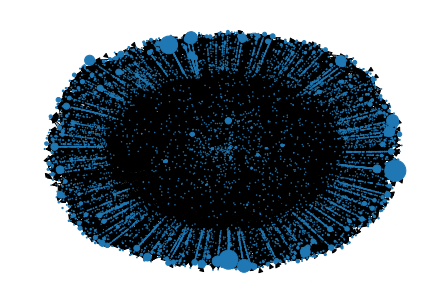

In [140]:
# and visualize it - 8000 is just a scaling factor to make the dots visible
nx.draw(g, node_size=[8000 * x for x in pagerank.values()])
plt.show()

## KLD

In [141]:
# Start by defining post content
submissions['content'] = submissions['body'] + submissions['title']

In [142]:
# A helper for calculating word frequencies
def p_dist(content):
    words = content.split() # tokenize by splitting on whitespace
    counts = collections.Counter(words)
    total = sum(counts.values())
    return {word: count / total for word, count in counts.items()}

# Calculate the word frequencies for every submission
submissions['word_p_dist'] = submissions['content'].apply(p_dist)

In [143]:
# And now calculating entropy is easy
submissions['entropy'] = submissions['word_p_dist'].apply(lambda d: scipy.stats.entropy(list(d.values()), base=2))

In [144]:
# A constant because 0 probabilities break math
infinitesimal = 0.0001

# Helper for calculating kld
def kld(word_freq1, word_freq2):
    if word_freq1 == None or word_freq2 == None:
        return np.nan
    p_dist1 = []
    p_dist2 = []
    for (word, freq) in word_freq1.items():
        p_dist1.append(freq)
        p_dist2.append(infinitesimal if not word in word_freq2 else word_freq2[word])
    for (word, freq) in word_freq2.items():
        if not word in word_freq1:
            p_dist1.append(infinitesimal)
            p_dist2.append(freq)
    return scipy.stats.entropy(p_dist1, p_dist2, base=2)

## simple test - should be equal
# scipy.stats.entropy([0.25, 0.75, infinitesimal], [0.5, 0.4, 0.1], base=2)
# kld({'a':0.25, 'b':0.75}, {'a':0.5, 'b':0.4, 'c':0.1})

In [145]:
# Calculate novelty
submissions['prev_submission_dist'] = submissions['word_p_dist'].shift(1).replace(to_replace={float("Nan"): None})
submissions['novelty'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['prev_submission_dist']), axis=1)
submissions = submissions.drop('prev_submission_dist', axis=1)

In [146]:
# And calculate transience
submissions['next_submission_dist'] = submissions['word_p_dist'].shift(-1).replace(to_replace={float("Nan"): None})
submissions['transience'] = submissions.apply(lambda row: kld(row['word_p_dist'], row['next_submission_dist']), axis=1)
submissions = submissions.drop('next_submission_dist', axis=1)

In [147]:
# Calculate novelty based on multiple previous submissions
window_size = 5

# Helper to average kld of multiple other submissions
def average_kld(of_dist, given_dists):
    if any(map(lambda x: x == None, given_dists)):
        return float("Nan")
    return np.mean(list(map(lambda given_dist: kld(of_dist, given_dist), given_dists)))

# Get the distributions of earlier submissions
submissions['prev_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['prev_dists'] = submissions['prev_dists'].combine(submissions['word_p_dist'].shift(i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['novelty_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['prev_dists']), axis=1)

# Cleanup
submissions = submissions.drop('prev_dists', axis=1)

In [148]:
# Get the distributions of later submissions
submissions['next_dists'] = submissions['word_p_dist'].apply(lambda x: list()) # get a sequence of empty lists
for i in range(1, window_size + 1):
    submissions['next_dists'] = submissions['next_dists'].combine(submissions['word_p_dist'].shift(-1 * i).replace(to_replace={float("Nan"): None}), lambda x, y: x + [y])

# And calculate novelty based on that window
submissions['transience_5'] = submissions.apply(lambda row: average_kld(row['word_p_dist'], row['next_dists']), axis=1)

# Cleanup
submissions = submissions.drop('next_dists', axis=1)

In [149]:
# Add a column for the difference between novelty and transience - let's call this... the impact
submissions['impact'] = submissions['novelty'] - submissions['transience']
submissions['impact_5'] = submissions['novelty_5'] - submissions['transience_5']

## Grouping By Users

In [150]:
user_submissions = submissions.groupby("user").apply(lambda g: pd.Series(
    {
        'num_posts': g['title'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g.apply(lambda row: len(row['title'] + row['body']), axis=1).mean(),
        'pagerank': pagerank[g['user'].iloc[0]], # weird indexing gets username and then finds pagerank for that user
        'mean_impact': g['impact'].mean(),
        'mean_novelty': g['novelty'].mean(),
        'mean_transience': g['transience'].mean(),
        'mean_impact_5': g['impact_5'].mean(),
        'mean_novelty_5': g['novelty_5'].mean(),
        'mean_transience_5': g['transience_5'].mean()
    }
))
user_submissions.head()

,num_posts,max_score,mean_score,min_score,mean_length,pagerank,mean_impact,mean_novelty,mean_transience,mean_impact_5,mean_novelty_5,mean_transience_5
user,,,,,,,,,,,,
-Lady-Stardust-,1.0,1230.0,1230.0,1230.0,252.0,0.000557,-1.769259,5.616547,7.385805,-0.195202,6.370761,6.565962
-Ph03niX-,1.0,13229.0,13229.0,13229.0,294.0,0.003135,-0.106176,7.261696,7.367873,-0.253938,6.955537,7.209475
02K30C1,2.0,78.0,75.5,73.0,206.5,0.000037,-0.039991,6.750453,6.790445,-0.154633,6.698299,6.852932
0neSock,1.0,19.0,19.0,19.0,151.0,0.000032,0.321412,8.049948,7.728537,0.146480,7.659414,7.512935
101_Almagamations,1.0,10.0,10.0,10.0,300.0,0.000125,-1.650203,5.094775,6.744978,-0.669324,6.165360,6.834684


In [151]:
user_comments = comments.groupby("user").apply(lambda g: pd.Series(
    {
        'num_comments': g['body'].size,
        'max_score': g['score'].max(),
        'mean_score': g['score'].mean(),
        'min_score': g['score'].min(),
        'mean_length': g['body'].apply(len).mean(),
        'pagerank': pagerank[g['user'].iloc[0]] # weird indexing gets username and then finds pagerank for that user
    }
))
user_comments.head()

,num_comments,max_score,mean_score,min_score,mean_length,pagerank
user,,,,,,
------__------------,1.0,2.0,2.0,2.0,181.0,0.000032
--coffeewench--,1.0,1.0,1.0,1.0,255.0,0.000032
-Already-Taken-,1.0,1.0,1.0,1.0,112.0,0.000032
-CluelessWoman-,1.0,5.0,5.0,5.0,24.0,0.000032
-DementedAvenger-,4.0,87.0,24.5,1.0,58.5,0.000032


## Merging the Tables

In [152]:
users = user_submissions.join(user_comments, how="outer", lsuffix="_submissions", rsuffix="_comments")

## Clean up after the merge

# outer join means pagerank may only be defined in one case and not the other - combine them
users['pagerank'] = users.apply(lambda row: row['pagerank_comments'] if np.isnan(row['pagerank_submissions']) else row['pagerank_submissions'], axis=1)
users = users.drop('pagerank_submissions', axis=1)
users = users.drop('pagerank_comments', axis=1)
users.head()

,num_posts,max_score_submissions,mean_score_submissions,min_score_submissions,mean_length_submissions,mean_impact,mean_novelty,mean_transience,mean_impact_5,mean_novelty_5,mean_transience_5,num_comments,max_score_comments,mean_score_comments,min_score_comments,mean_length_comments,pagerank
user,,,,,,,,,,,,,,,,,
------__------------,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,181.0,0.000032
--coffeewench--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,255.0,0.000032
-Already-Taken-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,112.0,0.000032
-CluelessWoman-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,5.0,5.0,24.0,0.000032
-DementedAvenger-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,87.0,24.5,1.0,58.5,0.000032


## Save the Data

In [153]:
save_path = "data/"
users.to_csv(save_path + subreddit + "-users-" + download_date_string + ".csv")
submissions.to_csv(save_path + subreddit + "-augmented-submissions-" + download_date_string + ".csv")
comments.to_csv(save_path + subreddit + "-augmented-comments-" + download_date_string + ".csv")

## EDA

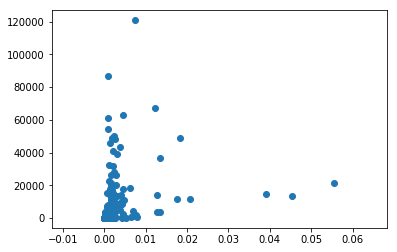

In [154]:
# mean score vs pagerank
plt.scatter(x=users['pagerank'], y=users['mean_score_submissions'])
plt.show()

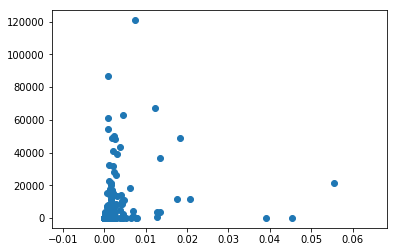

In [155]:
# min score vs pagerank
plt.scatter(x=users['pagerank'], y=users['min_score_submissions'])
plt.show()

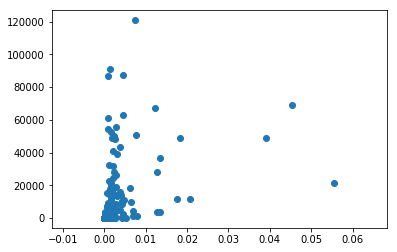

In [156]:
# max score vs pagerank
plt.scatter(x=users['pagerank'], y=users['max_score_submissions'])
plt.show()

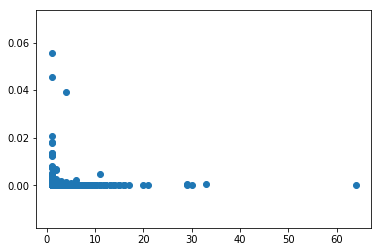

In [157]:
# number of comments vs pagerank
plt.scatter(x=users['num_comments'], y=users['pagerank'])
plt.show()

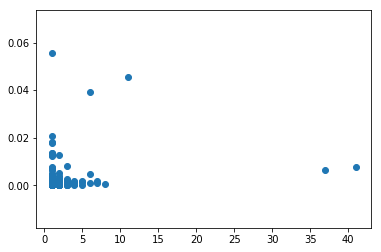

In [158]:
# number of posts vs pagerank - should be correlated (more submissions to comment on)
plt.scatter(x=users['num_posts'], y=users['pagerank'])
plt.show()
# okay, my hypothesis was wrong...

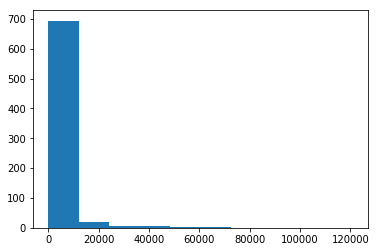

In [159]:
plt.hist(users['mean_score_submissions'])
plt.show()

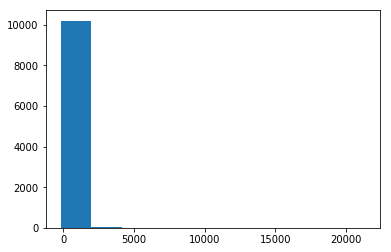

In [160]:
plt.hist(users['mean_score_comments'])
plt.show()

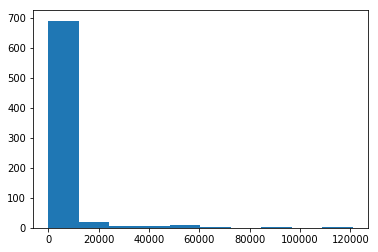

In [161]:
plt.hist(users['max_score_submissions'])
plt.show()

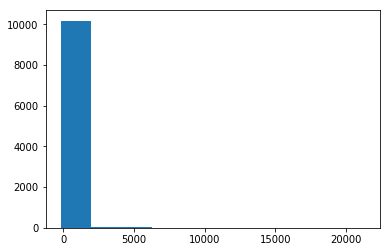

In [162]:
plt.hist(users['max_score_comments'])
plt.show()

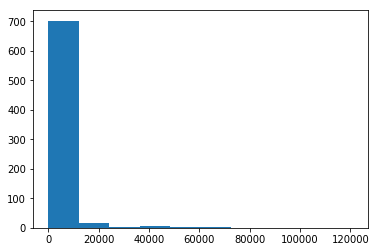

In [163]:
plt.hist(users['min_score_submissions'])
plt.show()

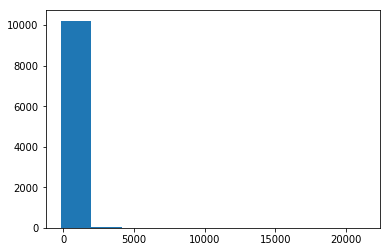

In [164]:
plt.hist(users['min_score_comments'])
plt.show()

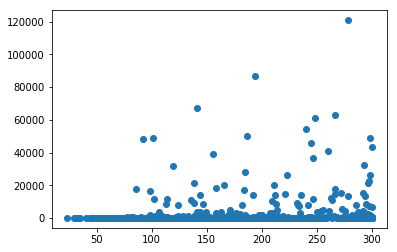

In [165]:
plt.scatter(x=users['mean_length_submissions'], y=users['mean_score_submissions'])
plt.show()

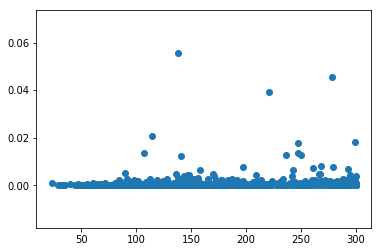

In [166]:
plt.scatter(x=users['mean_length_submissions'], y=users['pagerank'])
plt.show()

## Just Submission Stuff

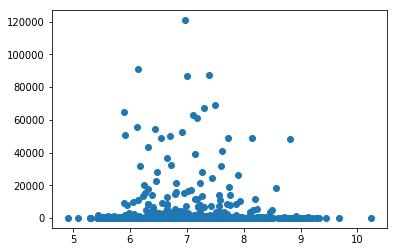

In [167]:
plt.scatter(x=submissions['novelty'], y=submissions['score'])
plt.show()

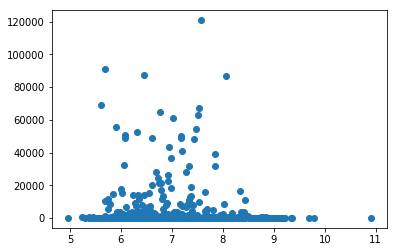

In [168]:
plt.scatter(x=submissions['transience'], y=submissions['score'])
plt.show()

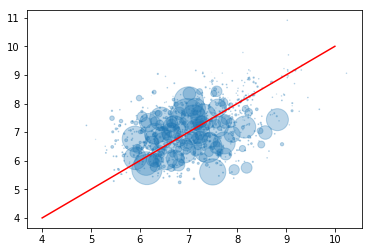

In [169]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty'], y=submissions['transience'], s=submissions['score'] / 100, alpha=0.3)

# add line of equality
domain = np.arange(4, 11)
plt.plot(domain, domain, color='red')
plt.show()

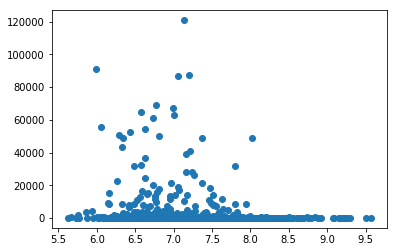

In [170]:
plt.scatter(x=submissions['novelty_5'], y=submissions['score'])
plt.show()

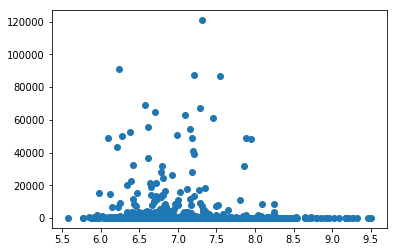

In [171]:
plt.scatter(x=submissions['transience_5'], y=submissions['score'])
plt.show()

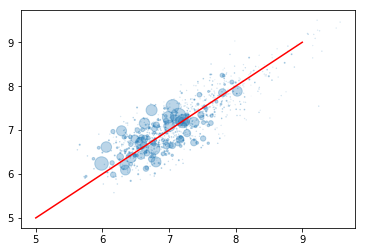

In [172]:
# novelty-transcience plot
plt.scatter(x=submissions['novelty_5'], y=submissions['transience_5'], s=submissions['score'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

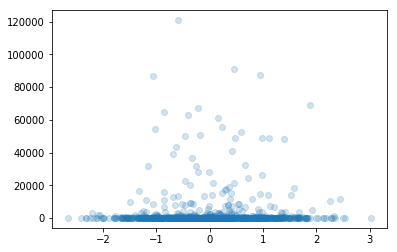

In [173]:
plt.scatter(x=submissions['impact'], y=submissions['score'], alpha=0.2)
plt.show()

## Users and KLD

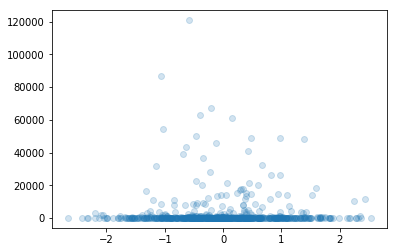

In [174]:
plt.scatter(x=users['mean_impact'], y=users['mean_score_submissions'], alpha=0.2)
plt.show()

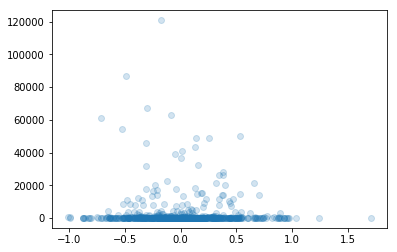

In [175]:
plt.scatter(x=users['mean_impact_5'], y=users['mean_score_submissions'], alpha=0.2)
plt.show()

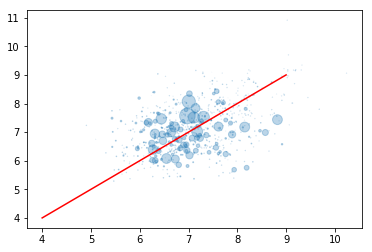

In [176]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty'], y=users['mean_transience'], s=users['mean_score_submissions'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(4, 10)
plt.plot(domain, domain, color='red')
plt.show()

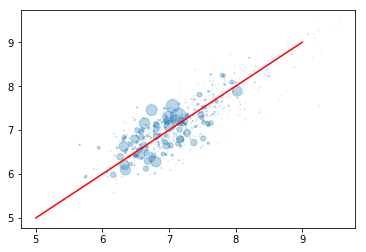

In [177]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty_5'], y=users['mean_transience_5'], s=users['mean_score_submissions'] / 500, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

## Pagerank and KLD for Users!!!

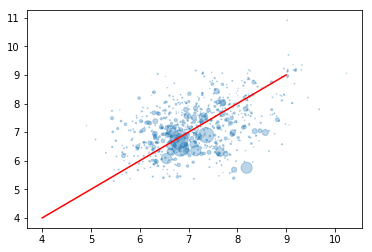

In [178]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty'], y=users['mean_transience'], s=users['pagerank']*6000, alpha=0.3)

# add line of equality
domain = np.arange(4, 10)
plt.plot(domain, domain, color='red')
plt.show()

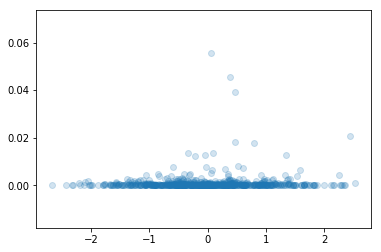

In [179]:
plt.scatter(x=users['mean_impact'], y=users['pagerank'], alpha=0.2)
plt.show()

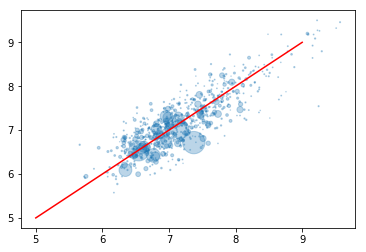

In [180]:
# novelty-transcience plot
plt.scatter(x=users['mean_novelty_5'], y=users['mean_transience_5'], s=users['pagerank']*9000, alpha=0.3)

# add line of equality
domain = np.arange(5, 10)
plt.plot(domain, domain, color='red')
plt.show()

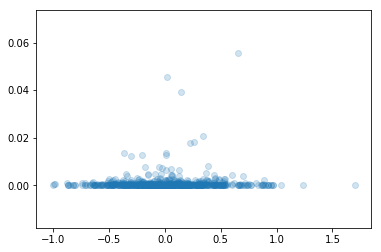

In [181]:
plt.scatter(x=users['mean_impact_5'], y=users['pagerank'], alpha=0.2)
plt.show()

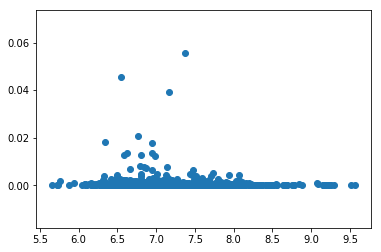

In [182]:
plt.scatter(x=users['mean_novelty_5'], y=users['pagerank'])
plt.show()